In [1]:
#use SMOTE oversampling
#random forest and Decision Tree

#for reference
#1 - Barn Cat    
#2 -Foster Home/ Fast Track     
#3 -Louisiana SPCA Offsite                     
#4 -Onsite     
#5 -Retail Partner Offsite 
#6 -Veterinary Partner Offsite 

import pandas as pd, numpy as np

from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelBinarizer

C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#read in data files
dogdata = pd.read_csv('Project_R_scripts\dogdata.csv') 

dogdata.columns

#remove outcome weekday when creating features
#remove offsite and foster as that provides future leakage information
dog_columns = ['IntakeMonth', 'IntakeWeekday', 'Log10AgeInMonths',
       'Male', 'AsilomarImprovement', 'HealthyAsilomar', 'TreatRehabAsilomar',
       'TreatManAsilomar', 'UnhealthyAsilomar', 'Emaciated', 'Feral',
       'Heartworm', 'SickInjured', 'SkinIssue', 'SurrenderIntake',
       'SeizeCustodyIntake', 'StrayIntake', 'TransferIntake', 'SmallAnimal',
       'AlteredAtIntake', 'DogEncouragement', 'DogMixed',
       'DogPitBullType']

dog_features = dogdata[dog_columns]
dog_target = dogdata['AdoptionChannelNum']


In [3]:
#split into train and testing sets
dog_X_train, dog_X_test, dog_y_train, dog_y_test = train_test_split(dog_features, dog_target, 
                                                                    test_size =0.33, random_state=0)
# number of samples in each set
print("No. of samples in training set: ", dog_X_train.shape[0])
print("No. of samples in validation set:", dog_X_test.shape[0])

No. of samples in training set:  3628
No. of samples in validation set: 1788


In [4]:
dog_y_train.value_counts()

4    2989
2     321
3     310
5       7
6       1
Name: AdoptionChannelNum, dtype: int64

In [5]:
#being that the majority of dogs are adopted through channels 2, 3, 4, aka 2 -Foster Home/ Fast Track, 
#3 -Louisiana SPCA Offsite, and #4 -Onsite, I'm going to exclude the other two from this analysis

dogdata = dogdata[dogdata.AdoptionChannelNum != 5]
dogdata = dogdata[dogdata.AdoptionChannelNum != 6]
dogdata.AdoptionChannelNum.value_counts()

4    4444
2     485
3     477
Name: AdoptionChannelNum, dtype: int64

In [6]:
#split into features, targets, and training/testing sets
dog_features = dogdata[dog_columns]
dog_target = dogdata['AdoptionChannelNum']

#split into train and testing sets
dog_X_train, dog_X_test, dog_y_train, dog_y_test = train_test_split(dog_features, dog_target, 
                                                                    test_size =0.33, random_state=0)
# number of samples in each set
print("No. of samples in training set: ", dog_X_train.shape[0])
print("No. of samples in validation set:", dog_X_test.shape[0])

No. of samples in training set:  3622
No. of samples in validation set: 1784


In [7]:
#resample according to the highest frequency
oversample = SMOTE(random_state=0)
dog_X_train, dog_y_train = oversample.fit_resample(dog_X_train, dog_y_train)

In [8]:
dog_y_train.value_counts()

4    2980
3    2980
2    2980
Name: AdoptionChannelNum, dtype: int64

In [9]:
# define model
model = DecisionTreeClassifier(max_depth=3, random_state=0)

# evaluate pipeline
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
#evaluate model
scores = cross_val_score(model, dog_X_train, dog_y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean Accuracy: 0.491 (0.011)


In [10]:
model.fit(dog_X_train, dog_y_train)
dog_y_pred = model.predict(dog_X_test)
print(metrics.accuracy_score(dog_y_pred, dog_y_test))
print(metrics.classification_report(dog_y_pred, dog_y_test))

0.422085201793722
              precision    recall  f1-score   support

           2       0.38      0.12      0.18       511
           3       0.33      0.11      0.16       511
           4       0.44      0.84      0.58       762

    accuracy                           0.42      1784
   macro avg       0.38      0.35      0.30      1784
weighted avg       0.39      0.42      0.34      1784



In [11]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)

    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return metrics.roc_auc_score(y_test, y_pred, average=average)

print(multiclass_roc_auc_score(dog_y_test, dog_y_pred) )

0.5340137515786675


C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


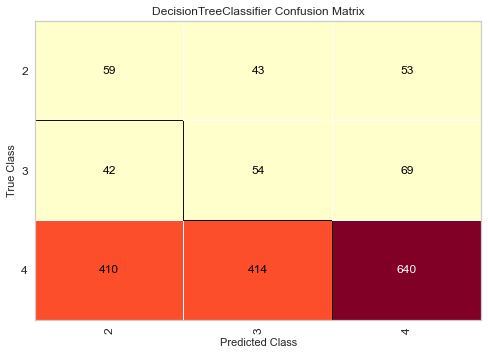

In [12]:
cm = ConfusionMatrix(model)
cm.fit(dog_X_train, dog_y_train)
cm.score(dog_X_test, dog_y_test)
cm.show()

In [13]:
# still oversampled
#define model
model = DecisionTreeClassifier(max_depth=5, random_state=0)

# evaluate pipeline
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
#evaluate model
scores = cross_val_score(model, dog_X_train, dog_y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean Accuracy: 0.550 (0.011)


In [14]:
model.fit(dog_X_train, dog_y_train)
dog_y_pred = model.predict(dog_X_test)
print(metrics.accuracy_score(dog_y_pred, dog_y_test))
print(metrics.classification_report(dog_y_pred, dog_y_test))

print(multiclass_roc_auc_score(dog_y_test, dog_y_pred) )

0.422085201793722
              precision    recall  f1-score   support

           2       0.41      0.11      0.18       564
           3       0.33      0.12      0.18       460
           4       0.43      0.83      0.57       760

    accuracy                           0.42      1784
   macro avg       0.39      0.36      0.31      1784
weighted avg       0.40      0.42      0.34      1784

0.5380759135163119


C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


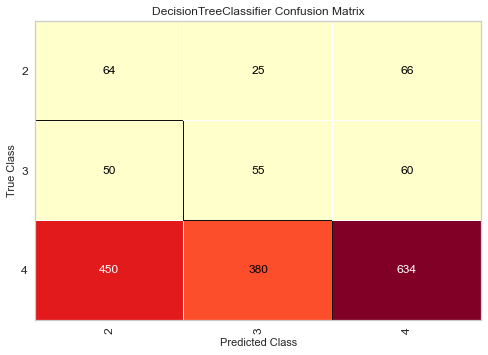

In [15]:
cm = ConfusionMatrix(model)
cm.fit(dog_X_train, dog_y_train)
cm.score(dog_X_test, dog_y_test)
cm.show()

C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


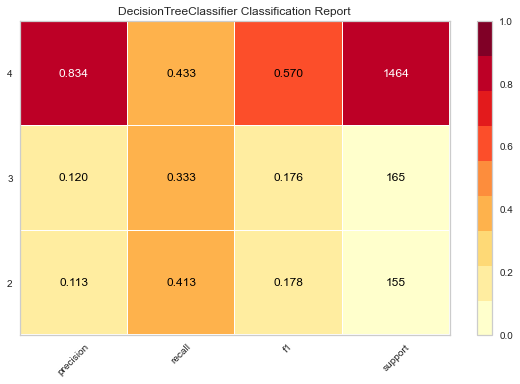

In [16]:
visualizer = ClassificationReport(model,  support=True)

visualizer.fit(dog_X_train, dog_y_train)       # Fit the visualizer and the model
visualizer.score(dog_X_test, dog_y_test)        # Evaluate the model on the test data
visualizer.show() 

In [17]:
# still oversampled
#define model
model = DecisionTreeClassifier(max_depth=8, random_state=0)

# evaluate pipeline
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
#evaluate model
scores = cross_val_score(model, dog_X_train, dog_y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean Accuracy: 0.632 (0.010)


In [18]:
model.fit(dog_X_train, dog_y_train)
dog_y_pred = model.predict(dog_X_test)
print(metrics.accuracy_score(dog_y_pred, dog_y_test))
print(metrics.classification_report(dog_y_pred, dog_y_test))

print(multiclass_roc_auc_score(dog_y_test, dog_y_pred) )

0.5364349775784754
              precision    recall  f1-score   support

           2       0.35      0.14      0.20       397
           3       0.24      0.11      0.15       362
           4       0.59      0.84      0.69      1025

    accuracy                           0.54      1784
   macro avg       0.39      0.36      0.35      1784
weighted avg       0.47      0.54      0.47      1784

0.5441637668595231


C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


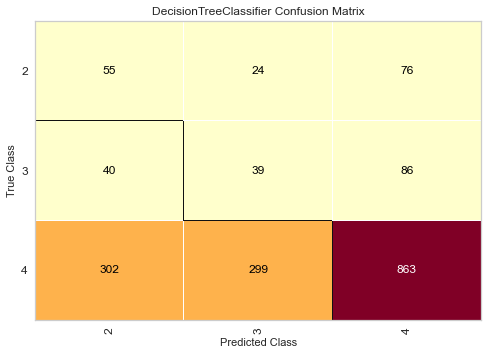

In [19]:
cm = ConfusionMatrix(model)
cm.fit(dog_X_train, dog_y_train)
cm.score(dog_X_test, dog_y_test)
cm.show()

In [20]:
dogdata.AdoptionChannelNum.value_counts()

4    4444
2     485
3     477
Name: AdoptionChannelNum, dtype: int64

C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


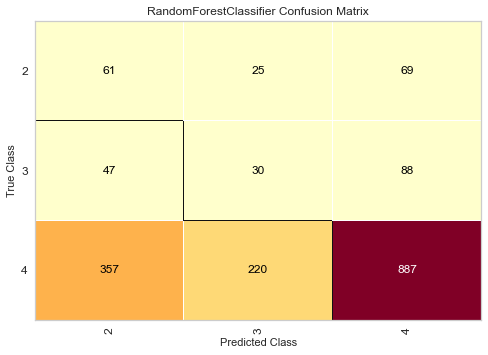

In [21]:
#try abalanced 
rf_model=RandomForestClassifier(class_weight='balanced', max_depth=3, random_state=0)

#evaluate on the test set
cm = ConfusionMatrix(rf_model)
cm.fit(dog_X_train, dog_y_train)
cm.score(dog_X_test, dog_y_test)
cm.show()

In [22]:
rf_model.fit(dog_X_train, dog_y_train)
dog_y_pred = rf_model.predict(dog_X_test)

print(metrics.accuracy_score(dog_y_pred, dog_y_test))
print(metrics.classification_report(dog_y_pred, dog_y_test))

print(multiclass_roc_auc_score(dog_y_test, dog_y_pred) )

0.5482062780269058
              precision    recall  f1-score   support

           2       0.39      0.13      0.20       465
           3       0.18      0.11      0.14       275
           4       0.61      0.85      0.71      1044

    accuracy                           0.55      1784
   macro avg       0.39      0.36      0.35      1784
weighted avg       0.49      0.55      0.49      1784

0.5485471657719663


C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


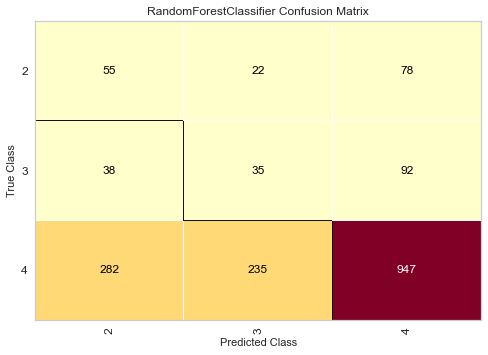

In [23]:
#try abalanced 
rf_model=RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=0)

#evaluate on the test set
cm = ConfusionMatrix(rf_model)
cm.fit(dog_X_train, dog_y_train)
cm.score(dog_X_test, dog_y_test)
cm.show()

In [24]:
rf_model.fit(dog_X_train, dog_y_train)
dog_y_pred = rf_model.predict(dog_X_test)

print(metrics.accuracy_score(dog_y_pred, dog_y_test))
print(metrics.classification_report(dog_y_pred, dog_y_test))

print(multiclass_roc_auc_score(dog_y_test, dog_y_pred) )

0.5812780269058296
              precision    recall  f1-score   support

           2       0.35      0.15      0.21       375
           3       0.21      0.12      0.15       292
           4       0.65      0.85      0.73      1117

    accuracy                           0.58      1784
   macro avg       0.40      0.37      0.36      1784
weighted avg       0.51      0.58      0.53      1784

0.5545647248166174


C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


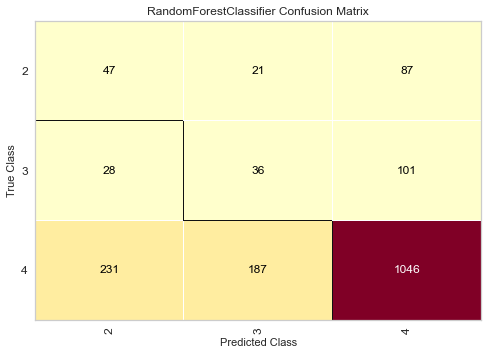

In [25]:
#try abalanced 
rf_model=RandomForestClassifier(class_weight='balanced', max_depth=8, random_state=0)

#evaluate on the test set
cm = ConfusionMatrix(rf_model)
cm.fit(dog_X_train, dog_y_train)
cm.score(dog_X_test, dog_y_test)
cm.show()

In [26]:
rf_model.fit(dog_X_train, dog_y_train)
dog_y_pred = rf_model.predict(dog_X_test)

print(metrics.accuracy_score(dog_y_pred, dog_y_test))
print(metrics.classification_report(dog_y_pred, dog_y_test))

print(multiclass_roc_auc_score(dog_y_test, dog_y_pred) )

0.632847533632287
              precision    recall  f1-score   support

           2       0.30      0.15      0.20       306
           3       0.22      0.15      0.18       244
           4       0.71      0.85      0.78      1234

    accuracy                           0.63      1784
   macro avg       0.41      0.38      0.39      1784
weighted avg       0.58      0.63      0.60      1784

0.5601534807776983


In [27]:
#try smote and random forest
#split into train and testing sets
dog_X_train, dog_X_test, dog_y_train, dog_y_test = train_test_split(dog_features, dog_target, 
                                                                    test_size =0.33, random_state=0)


#resample according to the highest frequency
oversample = SMOTE(random_state=0)
dog_X_train, dog_y_train = oversample.fit_resample(dog_X_train, dog_y_train)

In [28]:
#try abalanced 
rf_model=RandomForestClassifier(max_depth=3, random_state=0)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
#evaluate model
scores = cross_val_score(model, dog_X_train, dog_y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))



Mean Accuracy: 0.632 (0.010)


In [29]:
rf_model.fit(dog_X_train, dog_y_train)
dog_y_pred = rf_model.predict(dog_X_test)

print(metrics.accuracy_score(dog_y_pred, dog_y_test))
print(metrics.classification_report(dog_y_pred, dog_y_test))

print(multiclass_roc_auc_score(dog_y_test, dog_y_pred) )

0.5482062780269058
              precision    recall  f1-score   support

           2       0.39      0.13      0.20       465
           3       0.18      0.11      0.14       275
           4       0.61      0.85      0.71      1044

    accuracy                           0.55      1784
   macro avg       0.39      0.36      0.35      1784
weighted avg       0.49      0.55      0.49      1784

0.5485471657719663


C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


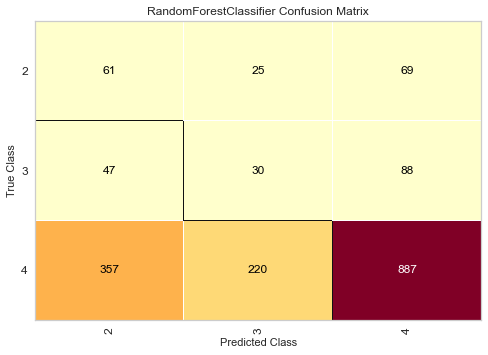

In [30]:
#evaluate on the test set
cm = ConfusionMatrix(rf_model)
cm.fit(dog_X_train, dog_y_train)
cm.score(dog_X_test, dog_y_test)
cm.show()

In [31]:
#try abalanced 
rf_model=RandomForestClassifier(max_depth=5, random_state=0)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
#evaluate model
scores = cross_val_score(model, dog_X_train, dog_y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))



Mean Accuracy: 0.632 (0.010)


In [32]:
rf_model.fit(dog_X_train, dog_y_train)
dog_y_pred = rf_model.predict(dog_X_test)

print(metrics.accuracy_score(dog_y_pred, dog_y_test))
print(metrics.classification_report(dog_y_pred, dog_y_test))

print(multiclass_roc_auc_score(dog_y_test, dog_y_pred) )

0.5812780269058296
              precision    recall  f1-score   support

           2       0.35      0.15      0.21       375
           3       0.21      0.12      0.15       292
           4       0.65      0.85      0.73      1117

    accuracy                           0.58      1784
   macro avg       0.40      0.37      0.36      1784
weighted avg       0.51      0.58      0.53      1784

0.5545647248166174


C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


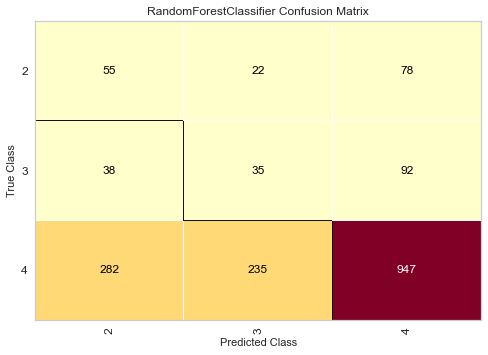

In [33]:
#evaluate on the test set
cm = ConfusionMatrix(rf_model)
cm.fit(dog_X_train, dog_y_train)
cm.score(dog_X_test, dog_y_test)
cm.show()

In [34]:
#try abalanced 
rf_model=RandomForestClassifier(max_depth=8, random_state=0)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
#evaluate model
scores = cross_val_score(model, dog_X_train, dog_y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))



Mean Accuracy: 0.632 (0.010)


In [35]:
rf_model.fit(dog_X_train, dog_y_train)
dog_y_pred = rf_model.predict(dog_X_test)

print(metrics.accuracy_score(dog_y_pred, dog_y_test))
print(metrics.classification_report(dog_y_pred, dog_y_test))

print(multiclass_roc_auc_score(dog_y_test, dog_y_pred) )

0.632847533632287
              precision    recall  f1-score   support

           2       0.30      0.15      0.20       306
           3       0.22      0.15      0.18       244
           4       0.71      0.85      0.78      1234

    accuracy                           0.63      1784
   macro avg       0.41      0.38      0.39      1784
weighted avg       0.58      0.63      0.60      1784

0.5601534807776983


C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


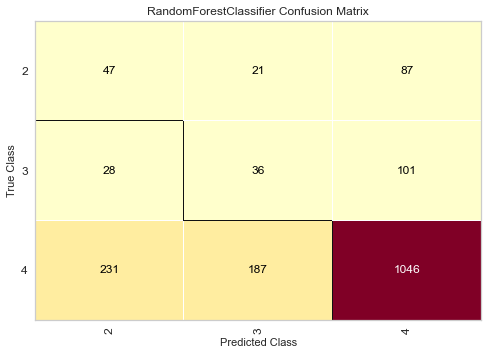

In [36]:
#evaluate on the test set
cm = ConfusionMatrix(rf_model)
cm.fit(dog_X_train, dog_y_train)
cm.score(dog_X_test, dog_y_test)
cm.show()

In [37]:
scores

array([0.61521253, 0.64653244, 0.64709172, 0.62695749, 0.63534676,
       0.6409396 , 0.63646532, 0.63590604, 0.63422819, 0.61744966,
       0.61800895, 0.63478747, 0.63702461, 0.61912752, 0.6303132 ])

In [38]:
#baseline KNN

#split into train and testing sets
dog_X_train, dog_X_test, dog_y_train, dog_y_test = train_test_split(dog_features, dog_target, 
                                                                    test_size =0.33, random_state=0)

model= KNeighborsClassifier()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
#evaluate model
scores = cross_val_score(model, dog_X_train, dog_y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean Accuracy: 0.798 (0.008)


In [50]:
model.n_neighbors

5

C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


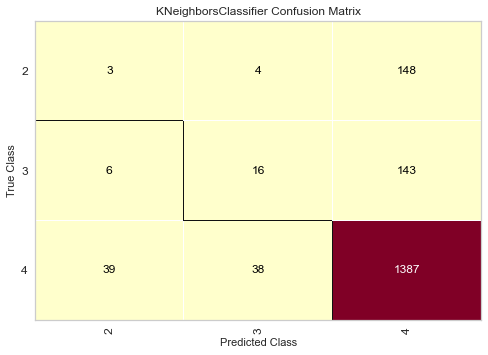

In [39]:
#evaluate on the test set
cm = ConfusionMatrix(model)
cm.fit(dog_X_train, dog_y_train)
cm.score(dog_X_test, dog_y_test)
cm.show()

In [40]:
dog_model = model.fit(dog_X_train, dog_y_train)
dog_y_pred = dog_model.predict(dog_X_test)
print(metrics.accuracy_score(dog_y_pred, dog_y_test))
print(metrics.classification_report(dog_y_pred, dog_y_test))

print(multiclass_roc_auc_score(dog_y_test, dog_y_pred) )

0.7881165919282511
              precision    recall  f1-score   support

           2       0.02      0.06      0.03        48
           3       0.10      0.28      0.14        58
           4       0.95      0.83      0.88      1678

    accuracy                           0.79      1784
   macro avg       0.35      0.39      0.35      1784
weighted avg       0.89      0.79      0.84      1784

0.5167979430671668


In [41]:
#try smote oversampling.\

#resample according to the highest frequency
oversample = SMOTE(random_state=0)
dog_X_train, dog_y_train = oversample.fit_resample(dog_X_train, dog_y_train)

In [42]:
#oversampled
knn_model= KNeighborsClassifier()

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
#evaluate model
scores = cross_val_score(model, dog_X_train, dog_y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))


Mean Accuracy: 0.786 (0.010)


C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


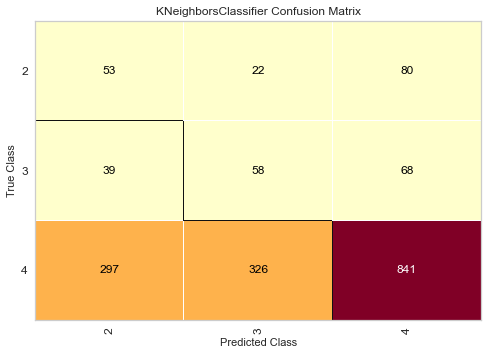

In [43]:

#evaluate on the test set
cm = ConfusionMatrix(knn_model)
cm.fit(dog_X_train, dog_y_train)
cm.score(dog_X_test, dog_y_test)
cm.show()

In [44]:
dog_knn_model = knn_model.fit(dog_X_train, dog_y_train)
dog_y_pred = dog_knn_model.predict(dog_X_test)
print(metrics.accuracy_score(dog_y_pred, dog_y_test))
print(metrics.classification_report(dog_y_pred, dog_y_test))

print(multiclass_roc_auc_score(dog_y_test, dog_y_pred) )

0.5336322869955157
              precision    recall  f1-score   support

           2       0.34      0.14      0.19       389
           3       0.35      0.14      0.20       406
           4       0.57      0.85      0.69       989

    accuracy                           0.53      1784
   macro avg       0.42      0.38      0.36      1784
weighted avg       0.47      0.53      0.47      1784

0.5640325297856561


In [45]:
dog_knn_model.n_neighbors

5

C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


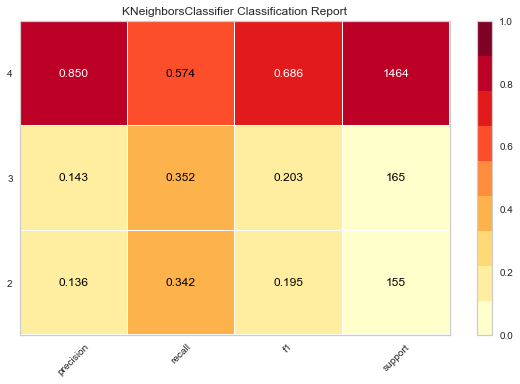

In [46]:
visualizer = ClassificationReport(knn_model,  support=True)

visualizer.fit(dog_X_train, dog_y_train)       # Fit the visualizer and the model
visualizer.score(dog_X_test, dog_y_test)        # Evaluate the model on the test data
visualizer.show() 

C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


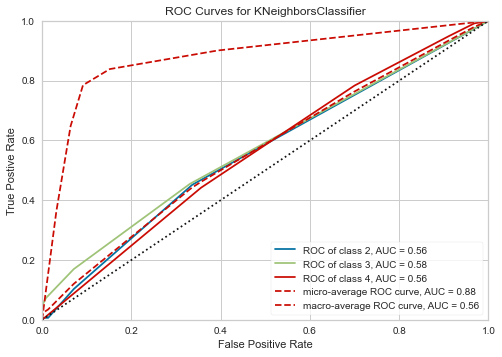

In [47]:
#recall is excellent for all classes 
visualizer = ROCAUC(dog_model)

visualizer.fit(dog_X_train, dog_y_train)        # Fit the visualizer and the model
visualizer.score(dog_X_test, dog_y_test)        # Evaluate the model on the test data
visualizer.show() 

C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


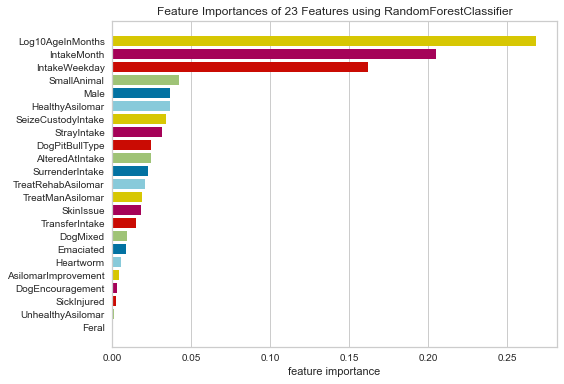

In [48]:
#knn does not have a coefficient or best feature model.  Getting them from the random forest
from yellowbrick.model_selection import FeatureImportances

viz = FeatureImportances(RandomForestClassifier(), relative=False)

# Fit and show the feature importances
viz.fit(dog_X_train, dog_y_train)
viz.show()

C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


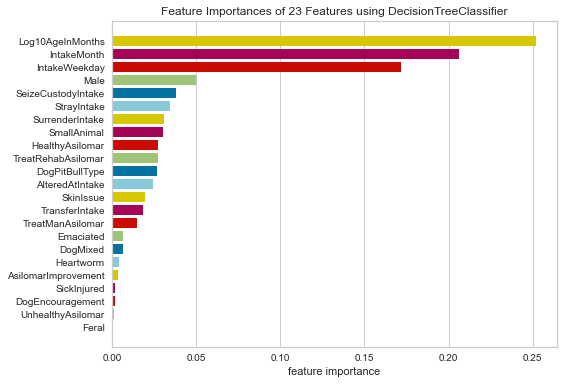

In [49]:
#knn does not have a coefficient or best feature model.  Getting them from the random forest
from yellowbrick.model_selection import FeatureImportances

viz = FeatureImportances(DecisionTreeClassifier(), relative=False)

# Fit and show the feature importances
viz.fit(dog_X_train, dog_y_train)
viz.show()